In [5]:
import pandas as pd
import xgboost as xgb
import numpy as np
import collections
import witwidget
import os, glob


from matplotlib import pyplot
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot


from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
 
    
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

In [6]:
# Set column dtypes for Pandas
from datetime import datetime
dt = datetime.utcnow()
COLUMN_NAMES = collections.OrderedDict({
  'Gmt time': object,
  'Open': np.float64,
  'High': np.float64,
  'Low': np.float64,
  'Close': np.float64,
  'Volume': np.float64,
  'Open_Bid': np.float64,
  'High_Bid': np.float64,
  'Low_Bid': np.float64,
  'Close_Bid': np.float64,
  'Volume_Bid': np.float64,
  'Spread': np.float64,
  'day_name': object,
  'weekday': 'category',#'category'np.int64
  'Pct_Range_Close': np.float64,
  'Pct_Range_Close_diff': np.float64,
  'MA_Close_5': np.float64,
  'MA_Close_25': np.float64,
  'MA_Close_50': np.float64,
  'MA_Close_200': np.float64,
  'EMA_Close_5': np.float64,
  'Momentum_1': np.float64,
  'Momentum_2': np.float64,
  'Momentum_5': np.float64,
  'Momentum_24': np.float64,
  'rsi': np.float64,
  'Rolling_Mean25': np.float64,
  'Bollinger_High': np.float64,
  'Bollinger_Low': np.float64,
  'PP': np.float64,
  'R1': np.float64,
  'S1': np.float64,
  'R2': np.float64,
  'S2': np.float64,
  'R3': np.float64,
  'S3': np.float64,
  'SO%k': np.float64,
  'SO%k1': np.float64,
  'SO%d2': np.float64,
  'Trix_5': np.float64,
  'MACD_5_25': np.float64,
  'MACDsign_5_25': np.float64,
  'MACDdiff_5_25': np.float64,
  'Mass_Index_25_8_9': np.float64,
  'Class': np.float64
})

In [7]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados_classification/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(filenames.index(file), ' ',os.path.basename(file))

0   3C-EURUSD_FULL_1D_145F.csv
1   3C-EURUSD_FULL_1D_21F.csv
2   3C-EURUSD_FULL_1D_45F.csv
3   3C-EURUSD_FULL_1D_70F.csv
4   3C-EURUSD_FULL_1H_145F.csv
5   3C-EURUSD_FULL_1H_45F.csv
6   3C-EURUSD_FULL_1H_70F.csv
7   5C-EURUSD_FULL_1D_21F.csv
8   5C-EURUSD_FULL_1D_45F.csv
9   C-EURUSD_FULL_1D_21F.csv
10   C-EURUSD_FULL_1H_25F.csv
11   C-EURUSD_FULL_1H_45F.csv
12   C-EURUSD_FULL_1H_54F.csv


In [8]:
#SELECT an INDEX 
INDX = 6


START_AT = 80000 # El dataset original de 1H es de 102514 registros, OJO Revisar Volume de 0 a 45000


CLASS_NUMBER = '3C'
MODEL_TYPE = 'XGBOOST'
FRECUENCIA = '1H'
TARGET_NAME = "Class"
ID = '03'

PROFUNDIDAD = 5

TEST_SIZE = .20
VAL_SIZE = .10

In [9]:
# Load data into Pandas
data = pd.read_csv(filenames[INDX], 
  index_col=False,
  dtype=COLUMN_NAMES
)
data = data.dropna()

#data = shuffle(data, random_state=2)
data.head()

,Gmt time,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,...,Trix_5,Trix_15,Trix_25,Trix_50,Trix_75,MACD_5_25,MACDsign_5_25,MACDdiff_5_25,Mass_Index_25_8_9,Class
0,2004-01-01 00:00:00,1.25950,1.25960,1.25826,1.25910,6654.2002,1.25934,1.25948,1.25814,1.25900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.237076,1.0
1,2004-01-01 01:00:00,1.25958,1.25960,1.25947,1.25951,660.6000,1.25942,1.25948,1.25934,1.25941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.237076,0.0
2,2004-01-01 02:00:00,1.25955,1.25962,1.25944,1.25951,2091.0000,1.25945,1.25948,1.25927,1.25936,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.237076,-1.0
3,2004-01-01 03:00:00,1.25950,1.25965,1.25834,1.25869,10003.0996,1.25934,1.25953,1.25821,1.25854,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.237076,1.0
4,2004-01-01 04:00:00,1.25908,1.25960,1.25843,1.25950,7603.3999,1.25898,1.25948,1.25829,1.25940,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.237076,0.0


In [10]:
DATASET_ORIGINAL = data
print(data.shape)
data1 = data.iloc[START_AT:]
data1.reset_index(drop=True, inplace=True)
data = data1
print(data.shape)
print(data)

(102514, 70)
(22514, 70)
                  Gmt time     Open     High      Low    Close      Volume  \
0      2016-10-19 03:00:00  1.09891  1.09930  1.09862  1.09906  27022.6191   
1      2016-10-19 04:00:00  1.09906  1.09909  1.09800  1.09802  28845.2305   
2      2016-10-19 05:00:00  1.09802  1.09831  1.09765  1.09823  27468.8809   
3      2016-10-19 06:00:00  1.09823  1.09856  1.09739  1.09826  43294.9102   
4      2016-10-19 07:00:00  1.09827  1.09923  1.09820  1.09913  56177.2109   
...                    ...      ...      ...      ...      ...         ...   
22509  2020-05-29 19:00:00  1.10998  1.11070  1.10862  1.10998  12120.8398   
22510  2020-05-29 20:00:00  1.10997  1.11094  1.10982  1.11071   4646.7427   
22511  2020-05-31 21:00:00  1.11213  1.11217  1.11136  1.11141    417.4906   
22512  2020-05-31 22:00:00  1.11138  1.11148  1.11028  1.11123   4549.1167   
22513  2020-05-31 23:00:00  1.11123  1.11199  1.11119  1.11158   5159.8101   

       Open_Bid  High_Bid  Low_Bid  Cl

In [11]:
data.columns

Index(['Gmt time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Open_Bid',
       'High_Bid', 'Low_Bid', 'Close_Bid', 'Volume_Bid', 'Spread', 'day_name',
       'weekday', 'Pct_Range_Close', 'Pct_Range_Close_diff', 'AQV',
       'AQM_Pct_Range_Close_diff', 'AQM_Pct_Range_Close', 'MA_Close_5',
       'MA_Close_25', 'MA_Close_50', 'MA_Close_100', 'MA_Close_150',
       'MA_Close_175', 'MA_Close_200', 'EMA_Close_5', 'Momentum_1',
       'Momentum_2', 'Momentum_3', 'Momentum_4', 'Momentum_5', 'Momentum_6',
       'Momentum_7', 'Momentum_8', 'Momentum_9', 'Momentum_10', 'Momentum_11',
       'Momentum_12', 'Momentum_13', 'Momentum_14', 'Momentum_15',
       'Momentum_25', 'Momentum_36', 'Momentum_50', 'Momentum_75',
       'Momentum_80', 'Momentum_100', 'rsi_5', 'rsi_14', 'rsi_25', 'rsi_50',
       'rsi_70', 'Rolling_Mean25', 'Bollinger_High', 'Bollinger_Low', 'SO_k',
       'SO%k1', 'SO%d2', 'Trix_2', 'Trix_5', 'Trix_15', 'Trix_25', 'Trix_50',
       'Trix_75', 'MACD_5_25', 'MACDsign_5_25', 

In [12]:
data = data.drop(['Gmt time'], axis = 1)
data = data.drop(['day_name'], axis = 1)
data = data.drop(['weekday'], axis = 1)
data = data.drop(['Open_Bid'], axis = 1)
data = data.drop(['High_Bid'], axis = 1)
data = data.drop(['Low_Bid'], axis = 1)
data = data.drop(['Close_Bid'], axis = 1)



data = data.drop(['EMA_Close_5'], axis = 1)

data.head()

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,Trix_5,Trix_15,Trix_25,Trix_50,Trix_75,MACD_5_25,MACDsign_5_25,MACDdiff_5_25,Mass_Index_25_8_9,Class
0,1.09891,1.09930,1.09862,1.09906,27022.6191,27279.3809,0.00003,0.000136,0.000764,1.891066e+09,...,0.000067,-0.000065,-0.000028,-0.000059,-0.000082,-0.000241,-0.000684,0.000442,25.005694,-1.0
1,1.09906,1.09909,1.09800,1.09802,28845.2305,27826.1992,0.00001,-0.000946,-0.001083,1.891095e+09,...,0.000041,-0.000064,-0.000029,-0.000058,-0.000081,-0.000442,-0.000635,0.000193,25.059314,0.0
2,1.09802,1.09831,1.09765,1.09823,27468.8809,25730.5293,0.00003,0.000191,0.001138,1.891122e+09,...,0.000013,-0.000063,-0.000031,-0.000058,-0.000081,-0.000501,-0.000609,0.000107,25.081024,0.0
3,1.09823,1.09856,1.09739,1.09826,43294.9102,49076.7109,0.00001,0.000027,-0.000164,1.891166e+09,...,-0.000008,-0.000062,-0.000032,-0.000057,-0.000080,-0.000517,-0.000590,0.000073,25.181015,1.0
4,1.09827,1.09923,1.09820,1.09913,56177.2109,61419.8008,0.00003,0.000792,0.000765,1.891222e+09,...,0.000008,-0.000059,-0.000033,-0.000057,-0.000079,-0.000290,-0.000530,0.000240,25.102276,1.0


In [13]:
SIZE = data.shape[0]
NUM_FEATURES = data.shape[1]
print(SIZE)
print(NUM_FEATURES)

22514
62


In [14]:
#LOCATION TO SAVE
pwd = os.getcwd()
source_data_toSave = os.path.join(pwd, r'../../../Models/2020/XGBoost/')
#print('Location to Save: ', source_data)
FILENAME = CLASS_NUMBER + '_' + FRECUENCIA + '_' + str(NUM_FEATURES) + 'F_' + str(SIZE) + 'Size_' + MODEL_TYPE +  '_' + TARGET_NAME + "_"+ ID 
file_name_toSave = FILENAME + '.bst'
print('FILENAME: ', FILENAME)
print('File Name Model:', file_name_toSave)

FILENAME:  3C_1H_62F_22514Size_XGBOOST_Class_03
File Name Model: 3C_1H_62F_22514Size_XGBOOST_Class_03.bst


In [15]:
train_dataset_results_csv = os.path.join(pwd, r'../../../Results/XGBoost/' + FILENAME + '_Train.csv')
print(train_dataset_results_csv)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models_clasification/../../../Results/XGBoost/3C_1H_62F_22514Size_XGBOOST_Class_03_Train.csv


In [16]:
test_dataset_results_csv = os.path.join(pwd, r'../../../Results/XGBoost/' + FILENAME + '_Test.csv')
print(test_dataset_results_csv)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models_clasification/../../../Results/XGBoost/3C_1H_62F_22514Size_XGBOOST_Class_03_Test.csv


In [17]:
# Label preprocessing
labels = data['Class'].values

# See the distribution of approved / denied classes (0: denied, 1: approved)
print(data['Class'].value_counts())

 0.0    8794
-1.0    6864
 1.0    6856
Name: Class, dtype: int64


In [18]:
data = data.drop(columns=['Class'])

In [19]:
def get_2Dimension(df, RANGE):
    new_df = pd.DataFrame()
    for i in range(RANGE):
#        new_df = df
        for j in range (df.shape[1]):
            #value = df.iloc[i+1,j]
            #print(value)
            new_col_name = df.columns[j] + '_' + str(i+1)
            #print(new_col_name)
            new_df[new_col_name] = df.iloc[i+1:,j]
            #print(new_df[new_col_name].isnull().sum())
            new_df.fillna(method='backfill', inplace=True)
            #print(new_df[new_col_name].isnull().sum())
    print(new_df.columns)
    return new_df

 


In [20]:
data

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,Trix_2,Trix_5,Trix_15,Trix_25,Trix_50,Trix_75,MACD_5_25,MACDsign_5_25,MACDdiff_5_25,Mass_Index_25_8_9
0,1.09891,1.09930,1.09862,1.09906,27022.6191,27279.3809,0.00003,0.000136,0.000764,1.891066e+09,...,0.000079,0.000067,-0.000065,-0.000028,-0.000059,-0.000082,-0.000241,-0.000684,0.000442,25.005694
1,1.09906,1.09909,1.09800,1.09802,28845.2305,27826.1992,0.00001,-0.000946,-0.001083,1.891095e+09,...,-0.000247,0.000041,-0.000064,-0.000029,-0.000058,-0.000081,-0.000442,-0.000635,0.000193,25.059314
2,1.09802,1.09831,1.09765,1.09823,27468.8809,25730.5293,0.00003,0.000191,0.001138,1.891122e+09,...,-0.000209,0.000013,-0.000063,-0.000031,-0.000058,-0.000081,-0.000501,-0.000609,0.000107,25.081024
3,1.09823,1.09856,1.09739,1.09826,43294.9102,49076.7109,0.00001,0.000027,-0.000164,1.891166e+09,...,-0.000116,-0.000008,-0.000062,-0.000032,-0.000057,-0.000080,-0.000517,-0.000590,0.000073,25.181015
4,1.09827,1.09923,1.09820,1.09913,56177.2109,61419.8008,0.00003,0.000792,0.000765,1.891222e+09,...,0.000179,0.000008,-0.000059,-0.000033,-0.000057,-0.000079,-0.000290,-0.000530,0.000240,25.102276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22509,1.10998,1.11070,1.10862,1.10998,12120.8398,11340.1201,0.00001,0.000009,-0.000739,2.123164e+09,...,-0.000073,-0.000202,0.000236,0.000237,0.000147,0.000093,0.000658,0.001882,-0.001224,25.246677
22510,1.10997,1.11094,1.10982,1.11071,4646.7427,4041.1875,0.00035,0.000658,0.000649,2.123169e+09,...,0.000193,-0.000172,0.000219,0.000233,0.000149,0.000094,0.000735,0.001653,-0.000918,25.191516
22511,1.11213,1.11217,1.11136,1.11141,417.4906,385.2600,0.00011,0.000630,-0.000027,2.123169e+09,...,0.000393,-0.000105,0.000204,0.000229,0.000150,0.000096,0.000943,0.001511,-0.000568,25.140431
22512,1.11138,1.11148,1.11028,1.11123,4549.1167,4784.7334,0.00005,-0.000162,-0.000792,2.123174e+09,...,0.000278,-0.000047,0.000190,0.000225,0.000152,0.000097,0.001000,0.001409,-0.000408,25.118420


In [21]:
pd_old_rows = get_2Dimension(data,PROFUNDIDAD)

Index(['Open_1', 'High_1', 'Low_1', 'Close_1', 'Volume_1', 'Volume_Bid_1',
       'Spread_1', 'Pct_Range_Close_1', 'Pct_Range_Close_diff_1', 'AQV_1',
       ...
       'Trix_2_5', 'Trix_5_5', 'Trix_15_5', 'Trix_25_5', 'Trix_50_5',
       'Trix_75_5', 'MACD_5_25_5', 'MACDsign_5_25_5', 'MACDdiff_5_25_5',
       'Mass_Index_25_8_9_5'],
      dtype='object', length=305)


In [22]:
pd_old_rows.shape

(22513, 305)

In [23]:
data = pd.concat([data, pd_old_rows], axis=1, sort=False)
data.fillna(method='backfill', inplace=True)
data.shape

(22514, 366)

In [24]:
data.head(30)

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,Trix_2_5,Trix_5_5,Trix_15_5,Trix_25_5,Trix_50_5,Trix_75_5,MACD_5_25_5,MACDsign_5_25_5,MACDdiff_5_25_5,Mass_Index_25_8_9_5
0,1.09891,1.09930,1.09862,1.09906,27022.6191,27279.3809,0.00003,0.000136,0.000764,1.891066e+09,...,0.000385,0.000052,-0.000054,-0.000033,-0.000056,-0.000079,0.000024,-0.000419,0.000443,25.102573
1,1.09906,1.09909,1.09800,1.09802,28845.2305,27826.1992,0.00001,-0.000946,-0.001083,1.891095e+09,...,0.000385,0.000052,-0.000054,-0.000033,-0.000056,-0.000079,0.000024,-0.000419,0.000443,25.102573
2,1.09802,1.09831,1.09765,1.09823,27468.8809,25730.5293,0.00003,0.000191,0.001138,1.891122e+09,...,0.000385,0.000052,-0.000054,-0.000033,-0.000056,-0.000079,0.000024,-0.000419,0.000443,25.102573
3,1.09823,1.09856,1.09739,1.09826,43294.9102,49076.7109,0.00001,0.000027,-0.000164,1.891166e+09,...,0.000385,0.000052,-0.000054,-0.000033,-0.000056,-0.000079,0.000024,-0.000419,0.000443,25.102573
4,1.09827,1.09923,1.09820,1.09913,56177.2109,61419.8008,0.00003,0.000792,0.000765,1.891222e+09,...,0.000385,0.000052,-0.000054,-0.000033,-0.000056,-0.000079,0.000024,-0.000419,0.000443,25.102573
5,1.09913,1.10049,1.09889,1.09978,55921.7813,69736.8672,0.00001,0.000591,-0.000201,1.891278e+09,...,0.000385,0.000052,-0.000054,-0.000033,-0.000056,-0.000079,0.000024,-0.000419,0.000443,25.102573
6,1.09978,1.09998,1.09917,1.09966,56268.7500,58972.4609,0.00003,-0.000109,-0.000700,1.891334e+09,...,0.000289,0.000088,-0.000048,-0.000032,-0.000055,-0.000078,0.000185,-0.000298,0.000484,25.074246
7,1.09966,1.10032,1.09852,1.09853,55378.1602,57868.0117,0.00003,-0.001028,-0.000918,1.891389e+09,...,-0.000137,0.000070,-0.000044,-0.000032,-0.000055,-0.000078,-0.000010,-0.000241,0.000231,25.155391
8,1.09853,1.09856,1.09728,1.09748,67623.4688,57583.9883,0.00001,-0.000956,0.000072,1.891457e+09,...,-0.000503,0.000003,-0.000042,-0.000032,-0.000054,-0.000077,-0.000399,-0.000272,-0.000126,25.181244
9,1.09748,1.09810,1.09612,1.09681,56928.1914,59748.7813,0.00002,-0.000610,0.000345,1.891514e+09,...,-0.000627,-0.000084,-0.000043,-0.000033,-0.000054,-0.000077,-0.000800,-0.000378,-0.000422,25.269968


In [25]:
# Convert categorical columns to dummy columns
dummy_columns = list(data.dtypes[data.dtypes == 'category'].index)
data = pd.get_dummies(data, columns=dummy_columns)

In [26]:
# Preview the data
data.head()

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,Trix_2_5,Trix_5_5,Trix_15_5,Trix_25_5,Trix_50_5,Trix_75_5,MACD_5_25_5,MACDsign_5_25_5,MACDdiff_5_25_5,Mass_Index_25_8_9_5
0,1.09891,1.09930,1.09862,1.09906,27022.6191,27279.3809,0.00003,0.000136,0.000764,1.891066e+09,...,0.000385,0.000052,-0.000054,-0.000033,-0.000056,-0.000079,0.000024,-0.000419,0.000443,25.102573
1,1.09906,1.09909,1.09800,1.09802,28845.2305,27826.1992,0.00001,-0.000946,-0.001083,1.891095e+09,...,0.000385,0.000052,-0.000054,-0.000033,-0.000056,-0.000079,0.000024,-0.000419,0.000443,25.102573
2,1.09802,1.09831,1.09765,1.09823,27468.8809,25730.5293,0.00003,0.000191,0.001138,1.891122e+09,...,0.000385,0.000052,-0.000054,-0.000033,-0.000056,-0.000079,0.000024,-0.000419,0.000443,25.102573
3,1.09823,1.09856,1.09739,1.09826,43294.9102,49076.7109,0.00001,0.000027,-0.000164,1.891166e+09,...,0.000385,0.000052,-0.000054,-0.000033,-0.000056,-0.000079,0.000024,-0.000419,0.000443,25.102573
4,1.09827,1.09923,1.09820,1.09913,56177.2109,61419.8008,0.00003,0.000792,0.000765,1.891222e+09,...,0.000385,0.000052,-0.000054,-0.000033,-0.000056,-0.000079,0.000024,-0.000419,0.000443,25.102573


In [27]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Bid', 'Spread',
       'Pct_Range_Close', 'Pct_Range_Close_diff', 'AQV',
       ...
       'Trix_2_5', 'Trix_5_5', 'Trix_15_5', 'Trix_25_5', 'Trix_50_5',
       'Trix_75_5', 'MACD_5_25_5', 'MACDsign_5_25_5', 'MACDdiff_5_25_5',
       'Mass_Index_25_8_9_5'],
      dtype='object', length=366)

In [28]:
# Split the data into train / test sets
x,y = data,labels
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size= TEST_SIZE, random_state=42, shuffle=False)

In [29]:
print(x_train.shape)
print(x_train)

(18011, 366)
          Open     High      Low    Close      Volume  Volume_Bid   Spread  \
0      1.09891  1.09930  1.09862  1.09906  27022.6191  27279.3809  0.00003   
1      1.09906  1.09909  1.09800  1.09802  28845.2305  27826.1992  0.00001   
2      1.09802  1.09831  1.09765  1.09823  27468.8809  25730.5293  0.00003   
3      1.09823  1.09856  1.09739  1.09826  43294.9102  49076.7109  0.00001   
4      1.09827  1.09923  1.09820  1.09913  56177.2109  61419.8008  0.00003   
...        ...      ...      ...      ...         ...         ...      ...   
18006  1.10435  1.10559  1.10424  1.10559  11274.4297  11021.3096  0.00002   
18007  1.10557  1.10637  1.10447  1.10579  11900.9297  11937.0000  0.00003   
18008  1.10579  1.10660  1.10549  1.10562   8447.7305   8178.8398  0.00004   
18009  1.10561  1.10683  1.10559  1.10599   5532.1899   5789.3301  0.00001   
18010  1.10599  1.10606  1.10537  1.10564   4540.8701   4328.5898  0.00002   

       Pct_Range_Close  Pct_Range_Close_diff      

In [30]:
print(x_test.shape)
x_test.reset_index(drop=True, inplace=True)
print(x_test)

(4503, 366)
         Open     High      Low    Close      Volume  Volume_Bid   Spread  \
0     1.10564  1.10569  1.10514  1.10524   3826.7600   3801.2900  0.00003   
1     1.10523  1.10543  1.10492  1.10493   2994.8201   3020.1699  0.00003   
2     1.10491  1.10505  1.10449  1.10492   1548.4700   1332.1300  0.00015   
3     1.10492  1.10521  1.10471  1.10497   1860.4100   1685.1851  0.00009   
4     1.10495  1.10527  1.10488  1.10490   1406.3499   1419.5551  0.00005   
...       ...      ...      ...      ...         ...         ...      ...   
4498  1.10998  1.11070  1.10862  1.10998  12120.8398  11340.1201  0.00001   
4499  1.10997  1.11094  1.10982  1.11071   4646.7427   4041.1875  0.00035   
4500  1.11213  1.11217  1.11136  1.11141    417.4906    385.2600  0.00011   
4501  1.11138  1.11148  1.11028  1.11123   4549.1167   4784.7334  0.00005   
4502  1.11123  1.11199  1.11119  1.11158   5159.8101   4047.4900  0.00002   

      Pct_Range_Close  Pct_Range_Close_diff           AQV  ... 

In [31]:
print(y_test.shape)
print(y_test)

(4503,)
[-1.  0.  0. ...  0.  1.  0.]


In [32]:
# Train the model, this will take a few minutes to run
bst = xgb.XGBClassifier(
    objective='reg:logistic'
)

bst.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
# Save the model so we can deploy it
#bst.save_model(source_data_toSave + file_name_toSave)

In [34]:
#bst_loaded = xgb.Booster({'nthread': 4})  # init model
#bst_loaded.load_model(source_data_toSave + file_name_toSave)  # load data

In [35]:
# Get predictions on the test set and print the accuracy score
y_pred = bst.predict(x_test)
acc = accuracy_score(y_test, y_pred.round())
print(acc, '\n')

0.4596935376415723 



In [36]:
# Print a confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred.round())
cm = cm / cm.astype(np.float).sum(axis=1)
print(cm)

Confusion matrix:
[[0.17303196 0.3516029  0.2962675 ]
 [0.14263445 0.74301965 0.24416796]
 [0.17303196 0.33764219 0.31959565]]


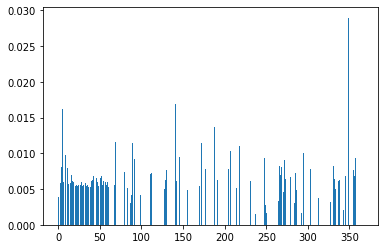

In [37]:

#print(bst.feature_importances_)
pyplot.bar(range(len(bst.feature_importances_)), bst.feature_importances_)
pyplot.show()

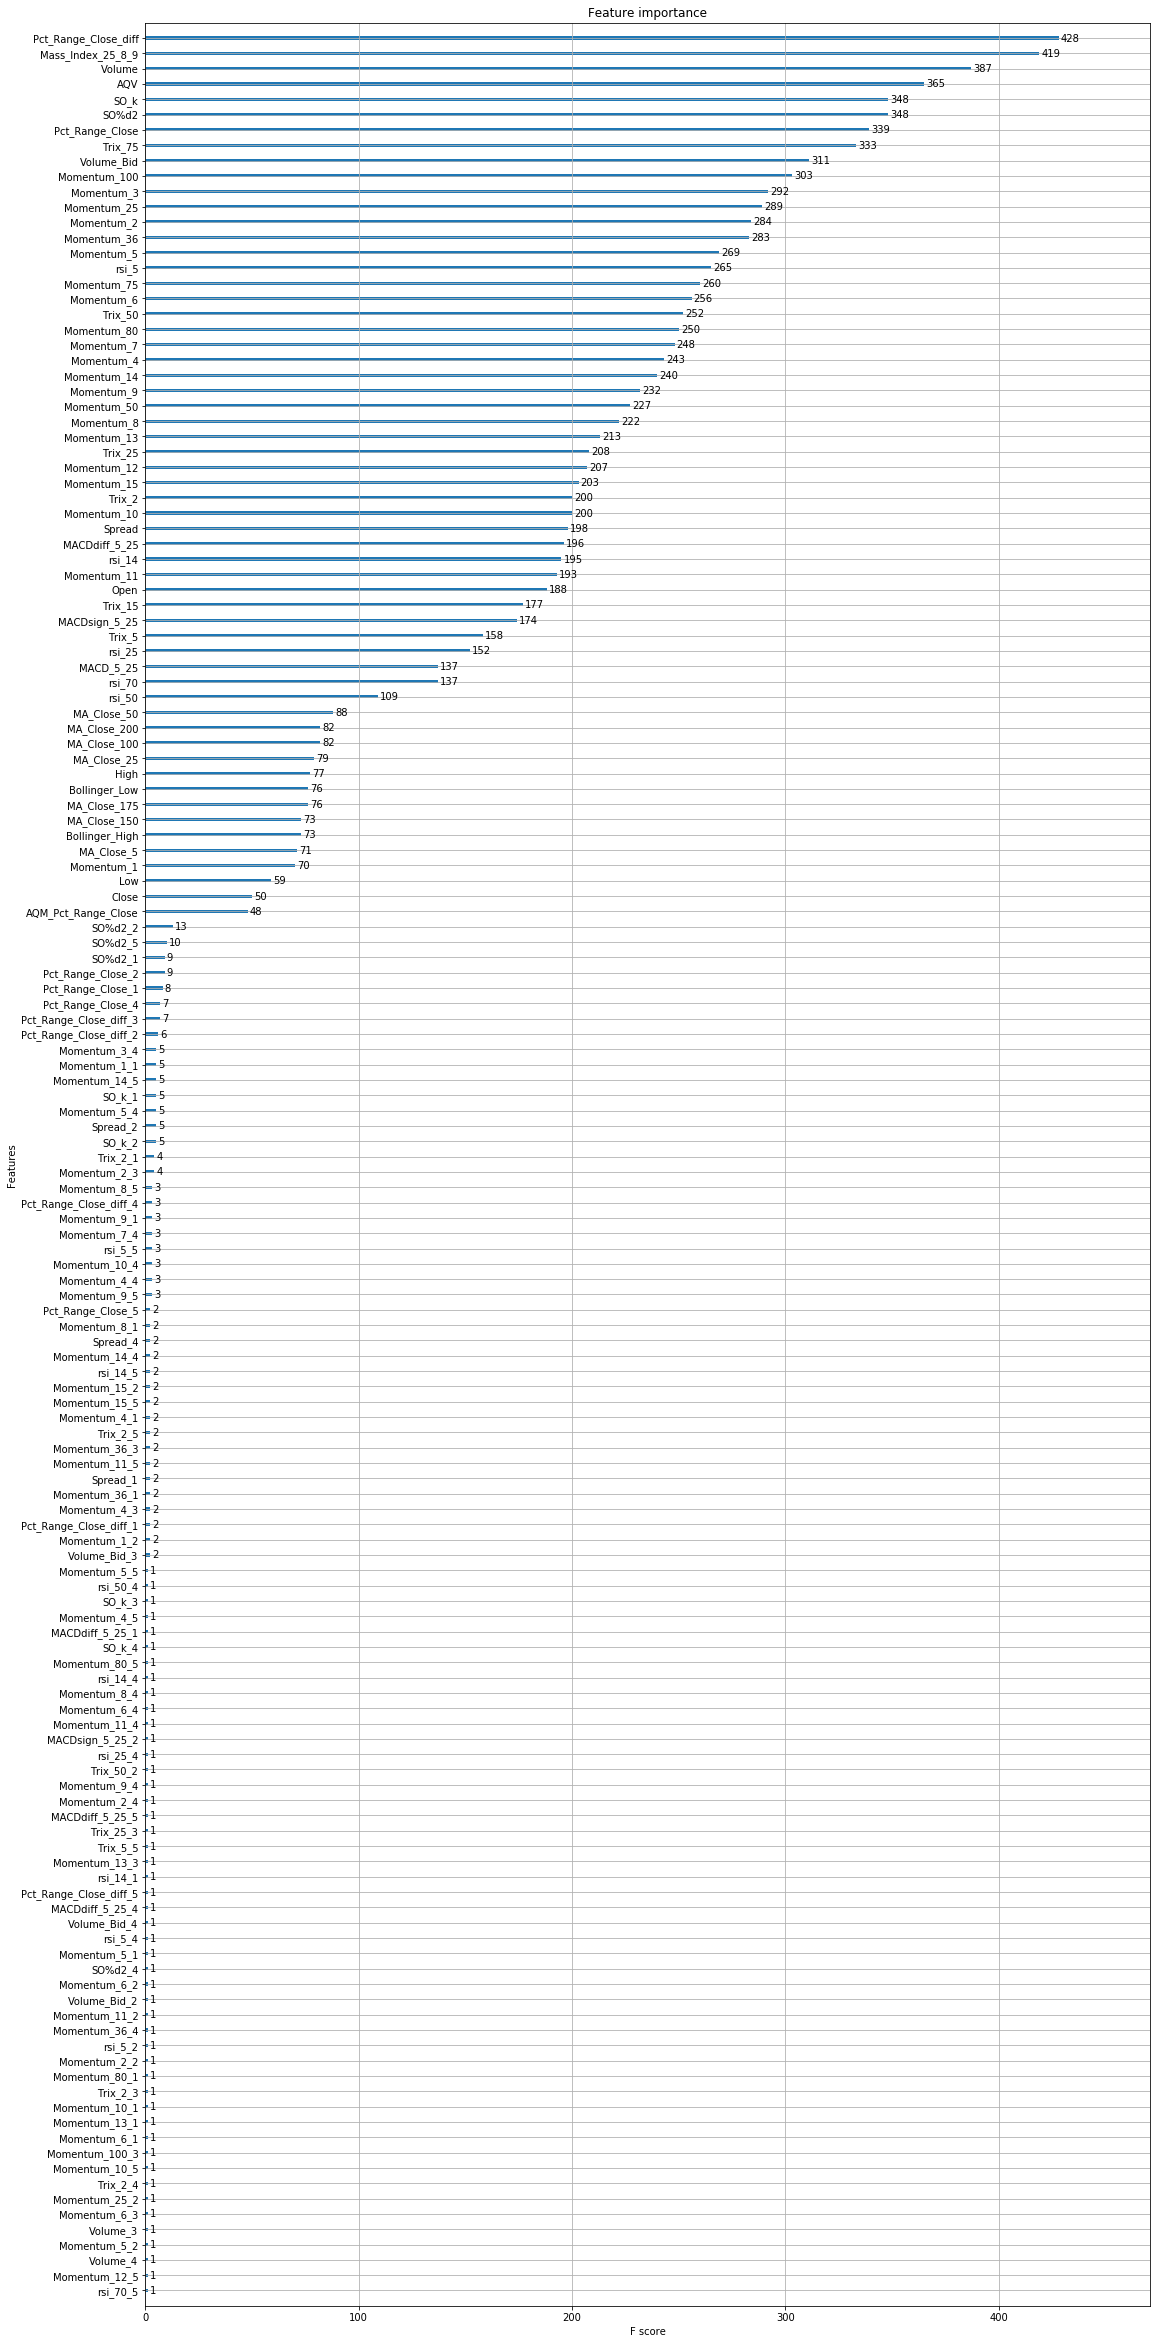

In [38]:
# plot feature importance
ax = plot_importance(bst)
fig = ax.figure
fig.set_size_inches(18, 42)
pyplot.show()

In [39]:
RUN_thresholds = False

# define custom class to fix bug in xgboost 1.0.2
class MyXGBClassifier(XGBClassifier):
    @property
    def coef_(self):
        return None

if (RUN_thresholds):
    # split data into X and y
    x,y = data,labels
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= TEST_SIZE, random_state=42,shuffle=False)

    # fit model on all training data
    model = MyXGBClassifier()
    model.fit(X_train, y_train)
    # make predictions for test data and evaluate
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # Fit model using each importance as a threshold
    thresholds = sort(model.feature_importances_)
    for thresh in thresholds:
        # select features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = XGBClassifier()
        selection_model.fit(select_X_train, y_train)
        # eval model
        select_X_test = selection.transform(X_test)
        predictions = selection_model.predict(select_X_test)
        accuracy = accuracy_score(y_test, predictions)
        print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

### Predict Train Dataset

In [40]:
y_train_pred = bst.predict(x_train)
#x_train,x_test,y_train,y_test

In [41]:
y_train_real = pd.DataFrame({'Real_Class': y_train})
y_train_pred_pd = pd.DataFrame({'Predicted_Class': y_train_pred})
print('y_train_real ',y_train_real.shape)
print('y_train_pred_pd ',y_train_pred_pd.shape)
x_train_real = pd.concat([x_train,y_train_real], axis=1, sort=False)
print('x_train_real ',x_train_real.shape)
x_train = pd.concat([x_train_real,y_train_pred_pd], axis=1, sort=False)
print('x_train ', x_train.shape)

y_train_real  (18011, 1)
y_train_pred_pd  (18011, 1)
x_train_real  (18011, 367)
x_train  (18011, 368)


In [42]:
#Save
x_train.to_csv(train_dataset_results_csv, header=True, index=False)
print(train_dataset_results_csv)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models_clasification/../../../Results/XGBoost/3C_1H_62F_22514Size_XGBOOST_Class_03_Train.csv


### Predict Test Dataset

In [43]:
x_test.shape
x_test

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,Trix_2_5,Trix_5_5,Trix_15_5,Trix_25_5,Trix_50_5,Trix_75_5,MACD_5_25_5,MACDsign_5_25_5,MACDdiff_5_25_5,Mass_Index_25_8_9_5
0,1.10564,1.10569,1.10514,1.10524,3826.7600,3801.2900,0.00003,-0.000362,-0.000045,2.088313e+09,...,-0.000103,0.000218,0.000043,0.000017,0.000033,0.000003,0.001242,0.000943,0.000299,24.853139
1,1.10523,1.10543,1.10492,1.10493,2994.8201,3020.1699,0.00003,-0.000280,0.000081,2.088316e+09,...,-0.000203,0.000159,0.000050,0.000019,0.000033,0.000004,0.001029,0.000960,0.000069,24.623666
2,1.10491,1.10505,1.10449,1.10492,1548.4700,1332.1300,0.00015,-0.000009,0.000271,2.088317e+09,...,-0.000168,0.000105,0.000055,0.000022,0.000033,0.000005,0.000869,0.000942,-0.000073,24.447890
3,1.10492,1.10521,1.10471,1.10497,1860.4100,1685.1851,0.00009,0.000045,0.000054,2.088319e+09,...,-0.000091,0.000064,0.000059,0.000024,0.000033,0.000005,0.000762,0.000906,-0.000144,24.299628
4,1.10495,1.10527,1.10488,1.10490,1406.3499,1419.5551,0.00005,-0.000063,-0.000109,2.088321e+09,...,-0.000061,0.000032,0.000062,0.000026,0.000033,0.000006,0.000658,0.000856,-0.000199,24.220745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4498,1.10998,1.11070,1.10862,1.10998,12120.8398,11340.1201,0.00001,0.000009,-0.000739,2.123164e+09,...,-0.000073,-0.000202,0.000236,0.000237,0.000147,0.000093,0.000658,0.001882,-0.001224,25.246677
4499,1.10997,1.11094,1.10982,1.11071,4646.7427,4041.1875,0.00035,0.000658,0.000649,2.123169e+09,...,0.000193,-0.000172,0.000219,0.000233,0.000149,0.000094,0.000735,0.001653,-0.000918,25.191516
4500,1.11213,1.11217,1.11136,1.11141,417.4906,385.2600,0.00011,0.000630,-0.000027,2.123169e+09,...,0.000393,-0.000105,0.000204,0.000229,0.000150,0.000096,0.000943,0.001511,-0.000568,25.140431
4501,1.11138,1.11148,1.11028,1.11123,4549.1167,4784.7334,0.00005,-0.000162,-0.000792,2.123174e+09,...,0.000278,-0.000047,0.000190,0.000225,0.000152,0.000097,0.001000,0.001409,-0.000408,25.118420


In [44]:
y_test_pred = bst.predict(x_test)
#x_train,x_test,y_train,y_test

In [45]:
y_test_pred.shape

(4503,)

In [46]:
y_test_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [47]:
y_test_real = pd.DataFrame({'Real_Class': y_test})
y_test_pred_pd = pd.DataFrame({'Predicted_Class': y_test_pred})
print('y_test_real ',y_test_real.shape)
print('y_test_pred_pd ',y_test_pred_pd.shape)
x_test_real = pd.concat([x_test,y_test_real], axis=1, sort=False)
print('x_test_real ',x_test_real.shape)
x_test = pd.concat([x_test_real,y_test_pred_pd], axis=1, sort=False)
print('x_test ', x_test.shape)

y_test_real  (4503, 1)
y_test_pred_pd  (4503, 1)
x_test_real  (4503, 367)
x_test  (4503, 368)


In [48]:

print(x_test['Predicted_Class'].isnull().sum())
#DATASET_FULL.fillna(method='backfill', inplace=True)

0


In [49]:
#Save
x_test.to_csv(test_dataset_results_csv, header=True, index=False)
print(test_dataset_results_csv)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models_clasification/../../../Results/XGBoost/3C_1H_62F_22514Size_XGBOOST_Class_03_Test.csv
